# Surface concentrations

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from itertools import compress
import datetime as dt
from datetime import date

%matplotlib inline

###### Parameters:

In [2]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax - imin
jsize = jmax - jmin

land_color = '#8b7765'

# model results:
year = 2002

base_old    = '/data/brogalla/run_storage/Mn-reference-202103/spin-up0-202103/'
base_tuning = '/data/brogalla/run_storage/mn-reference-test-spin-up0-202105/'

###### Load files:

In [4]:
ref   = nc.Dataset(base_old+'ANHA12_EXH006_'+str(year)+'_monthly.nc',  'r')
lons  = np.array(ref.variables['nav_lon'])
lats  = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

In [5]:
results_00  = nc.Dataset(base_old+'ANHA12_EXH006_'+str(year)+'_monthly.nc')
dissolmn_old0 = np.array(results_00.variables['dissolmn'][:,0,:,:,:])*10**9 # nM units
oxidismn_old0 = np.array(results_00.variables['oxidismn'][:,0,:,:,:])*10**9 # nM units
results_00.close()

In [6]:
results_10  = nc.Dataset(base_tuning+'ANHA12_EXH006_'+str(year)+'_monthly.nc')
dissolmn_10 = np.array(results_10.variables['dissolmn'][:,0,:,:,:])*10**9 # nM units
oxidismn_10 = np.array(results_10.variables['oxidismn'][:,0,:,:,:])*10**9 # nM units
results_10.close()

In [7]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask     = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 

##### Functions:

In [73]:
def plot_experiment(ax, variable, month=0, layer=0, vmin=0, vmax=7, cmap=cmocean.cm.dense):
    proj1 = Basemap(projection='stere',lat_0 = 77.1, lon_0 = -85, resolution='i', width=4.5e6, height=2.98e6, ax=ax)
    proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=5);
    x, y = proj1(lons, lats)
    
    var = np.ma.masked_where(tmask[layer,:,:] < 0.1, variable[month,layer,:,:])
    
    c1 = proj1.contourf(x, y, var, np.arange(vmin,vmax+1,0.25),\
                             cmap=cmap, vmin=vmin, vmax=vmax, extend='both')
    
    return c1

In [94]:
def plot_comparison(month=0, layer=0):
    
    fig, ax = plt.subplots(1,3, figsize=(20,4))

    fig.suptitle(f'Dissolved Mn for month index {month}, depth layer {layer}', fontsize=14)

    # Panel A & B: 
    c1 = plot_experiment(ax[0], dissolmn_old0, vmax=12, month=month, layer=layer)
    c2 = plot_experiment(ax[1], dissolmn_10  , vmax=12, month=month, layer=layer)
    c3 = plot_experiment(ax[2], dissolmn_10-dissolmn_old0, vmin=-4, vmax=4, cmap=cmocean.cm.balance, month=month, layer=layer)
    ax[0].set_title('Reference exp (Mn-reference-202103)', fontsize=12)
    ax[1].set_title('Sinking fixed', fontsize=12)
    ax[2].set_title('Difference', fontsize=12)

    cbar_ax1 = fig.add_axes([0.13, 0.15, 0.02, 0.25])
    cbar_ax2 = fig.add_axes([0.41, 0.15, 0.02, 0.25])
    cbar_ax3 = fig.add_axes([0.68, 0.15, 0.02, 0.25])
    cbar1    = fig.colorbar(c1, cax=cbar_ax1, ticks=np.arange(0,14,4))
    cbar2    = fig.colorbar(c2, cax=cbar_ax2, ticks=np.arange(0,14,4))
    cbar3    = fig.colorbar(c3, cax=cbar_ax3, ticks=np.linspace(-4,4,5))

    return

### Profiles:

In [125]:
# Average over a region in central Canada Basin
month=7
i  = 608
j  = 418
di = 30
dj = 30

dmn_old = dissolmn_old0[month,:,i-di:i+di,j-dj:j+dj].mean(axis=(1,2))
dmn_new = dissolmn_10[month,:,i-di:i+di,j-dj:j+dj].mean(axis=(1,2))
omn_old = oxidismn_old0[month,:,i-di:i+di,j-dj:j+dj].mean(axis=(1,2))
omn_new = oxidismn_10[month,:,i-di:i+di,j-dj:j+dj].mean(axis=(1,2))

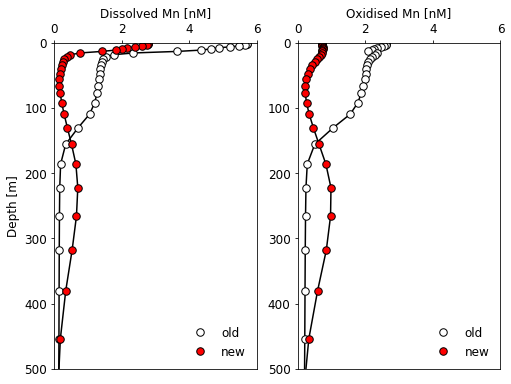

In [129]:
fig, ax = plt.subplots(1,2, figsize=(8,6))
    
ax[0].set_title('Dissolved Mn [nM]', fontsize=12)
ax[0].plot(dmn_old, depth, '-k')
ax[0].plot(dmn_old, depth, '.w', markersize=15, markeredgecolor='k', label='old')
ax[0].plot(dmn_new, depth, '-k')
ax[0].plot(dmn_new, depth, '.r', markersize=15, markeredgecolor='k', label='new')

ax[1].set_title('Oxidised Mn [nM]', fontsize=12)
ax[1].plot(omn_old, depth, '-k')
ax[1].plot(omn_old, depth, '.w', markersize=15, markeredgecolor='k', label='old')
ax[1].plot(omn_new, depth, '-k')
ax[1].plot(omn_new, depth, '.r', markersize=15, markeredgecolor='k', label='new')

ax[0].set_ylabel('Depth [m]', fontsize=12)

for axis in ax.ravel():
    axis.invert_yaxis()
    axis.set_xlim(0,6)
    axis.set_ylim(500,0)
    axis.tick_params(axis='both', labelsize=12)
    axis.xaxis.tick_top()    
    axis.xaxis.set_label_position('top') 
    axis.legend(fontsize=12, frameon=False, loc=4)

### dissolved Mn concentrations:

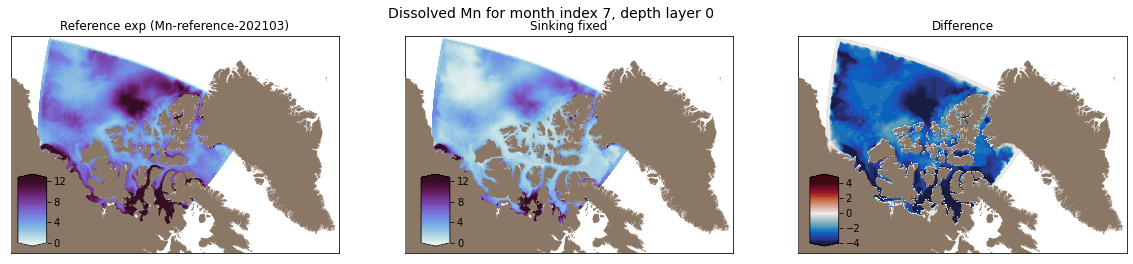

In [85]:
plot_comparison(month=7,layer=0)

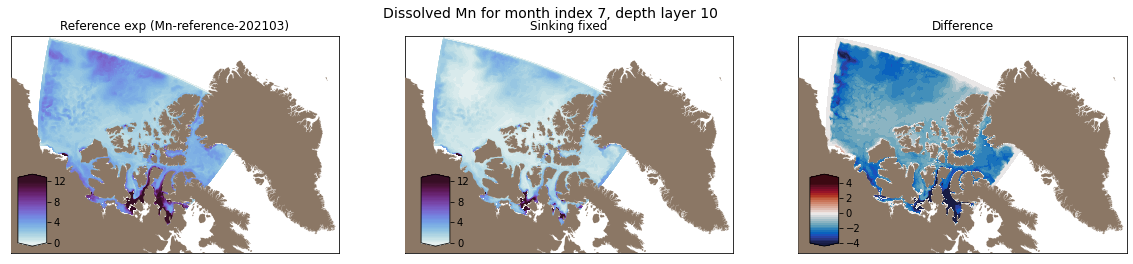

In [86]:
plot_comparison(month=7,layer=10)

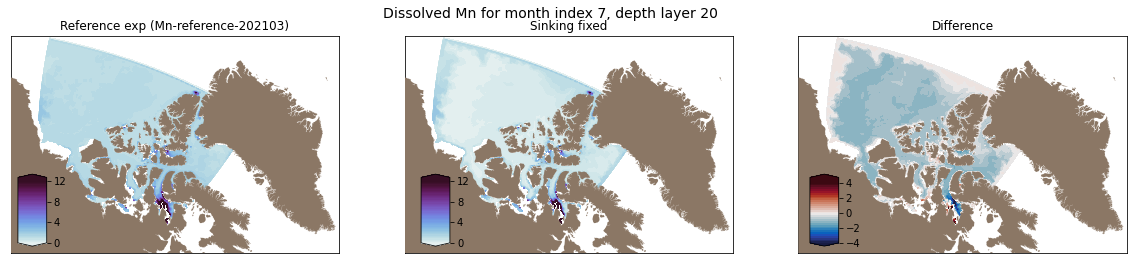

In [87]:
plot_comparison(month=7,layer=20)

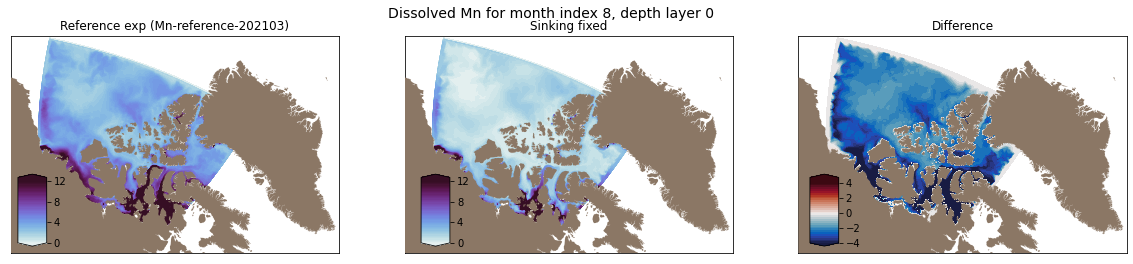

In [88]:
plot_comparison(month=8,layer=0)

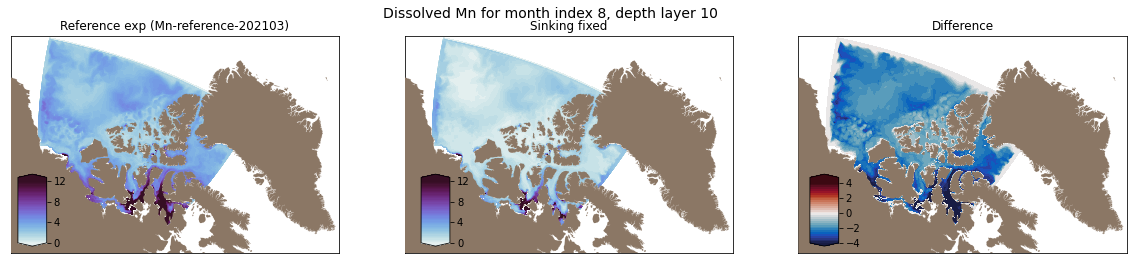

In [89]:
plot_comparison(month=8,layer=10)

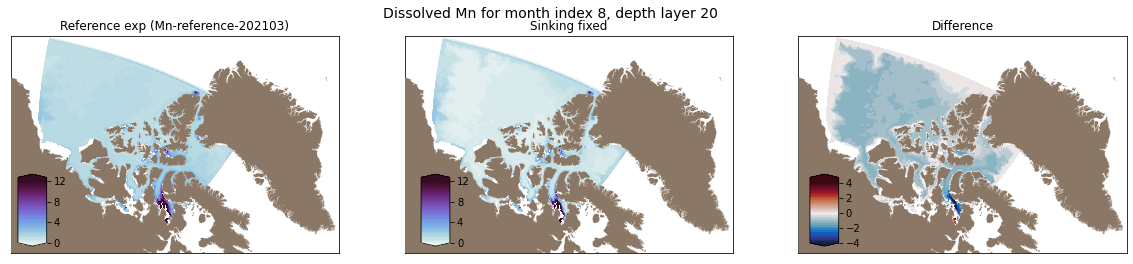

In [90]:
plot_comparison(month=8,layer=20)

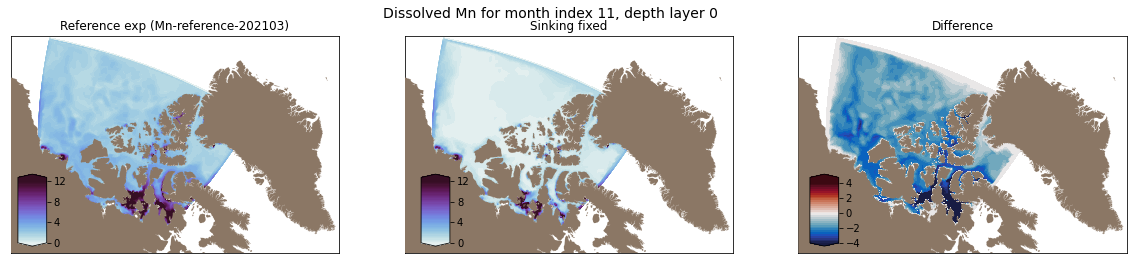

In [91]:
plot_comparison(month=11,layer=0)

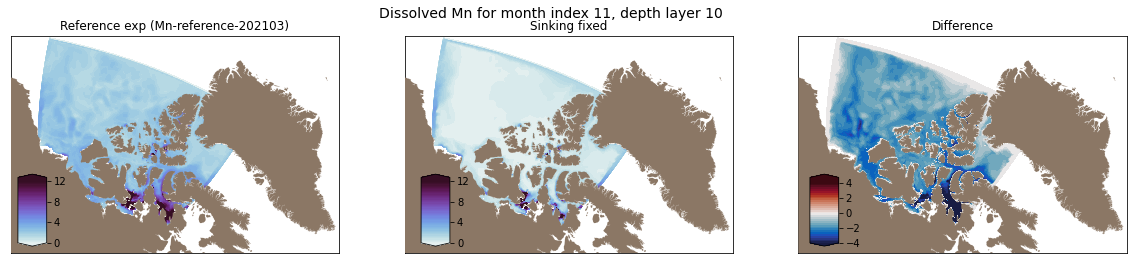

In [92]:
plot_comparison(month=11,layer=10)

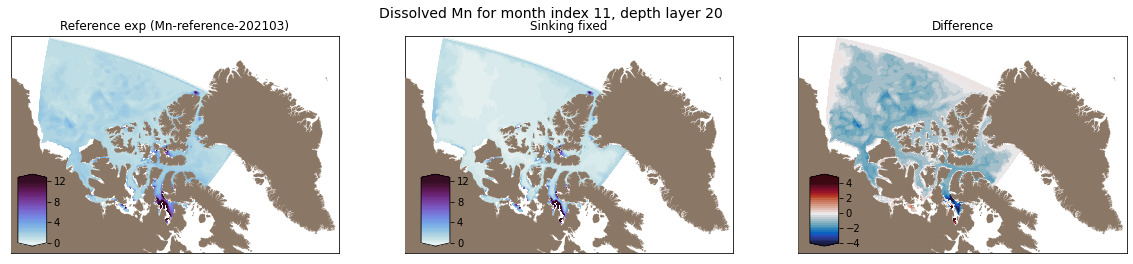

In [93]:
plot_comparison(month=11,layer=20)

### oxidised Mn concentrations:

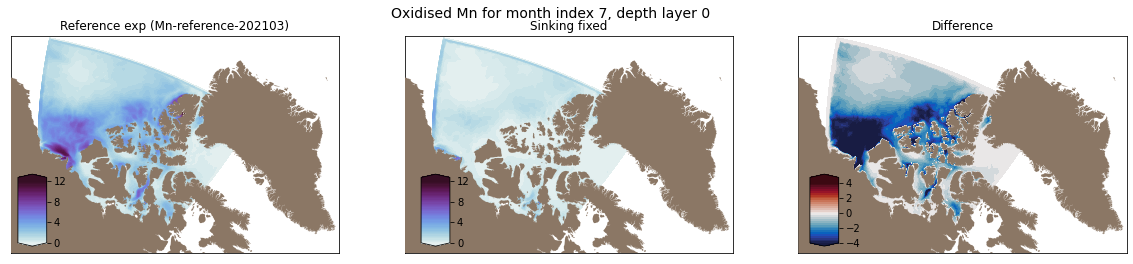

In [95]:
plot_comparison(month=7,layer=0)

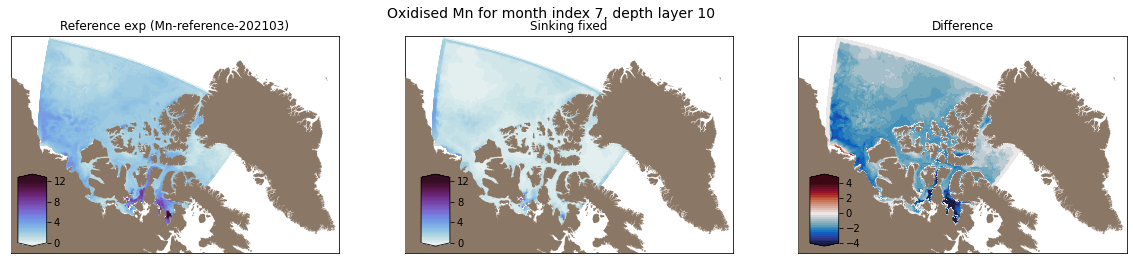

In [96]:
plot_comparison(month=7,layer=10)

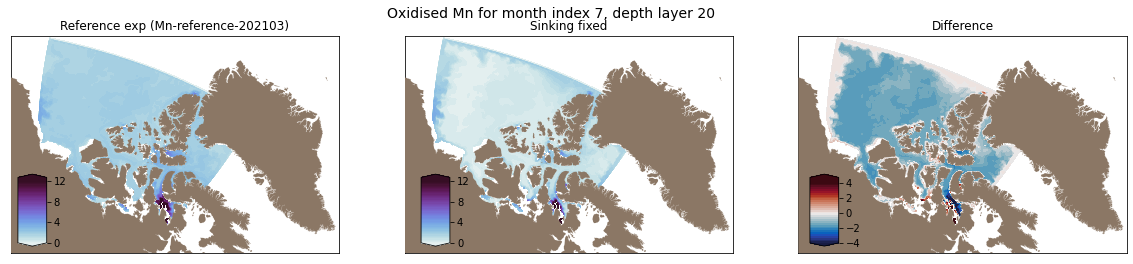

In [97]:
plot_comparison(month=7,layer=20)

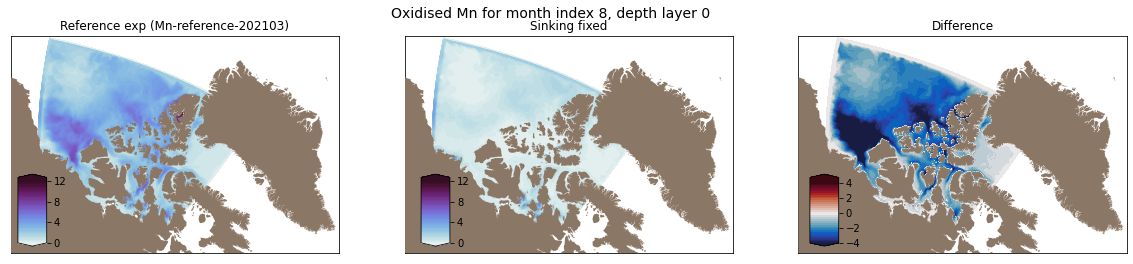

In [98]:
plot_comparison(month=8,layer=0)

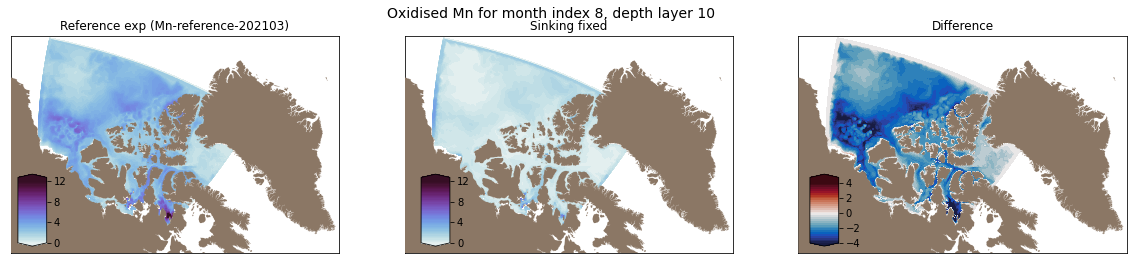

In [99]:
plot_comparison(month=8,layer=10)

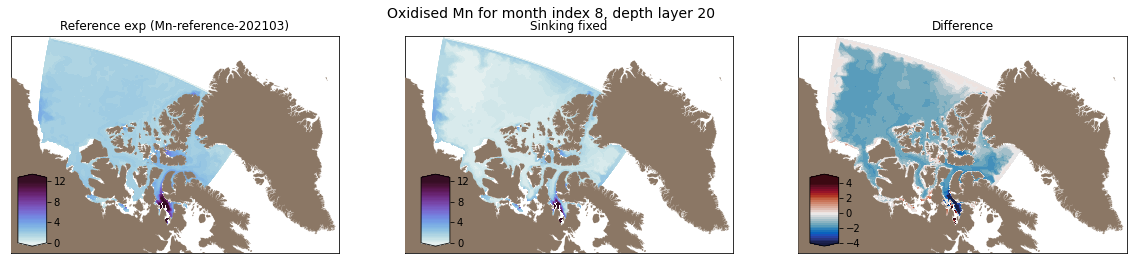

In [100]:
plot_comparison(month=8,layer=20)

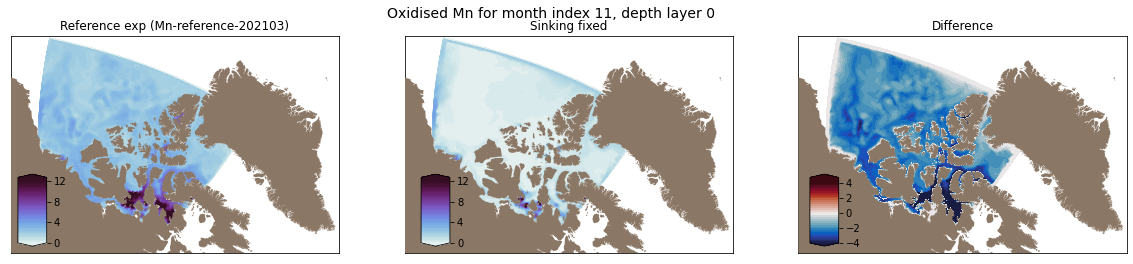

In [101]:
plot_comparison(month=11,layer=0)

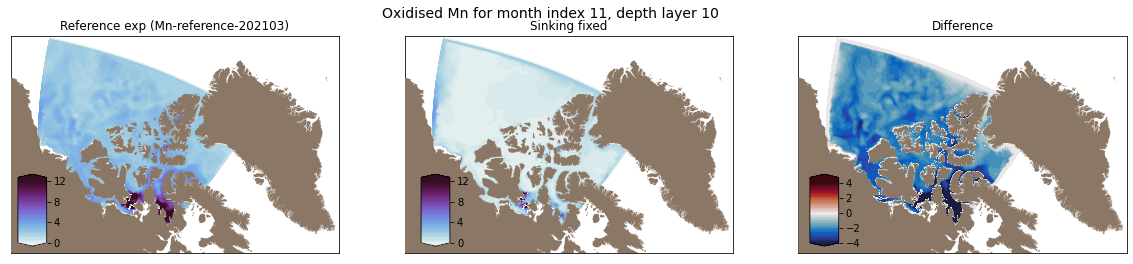

In [102]:
plot_comparison(month=11,layer=10)

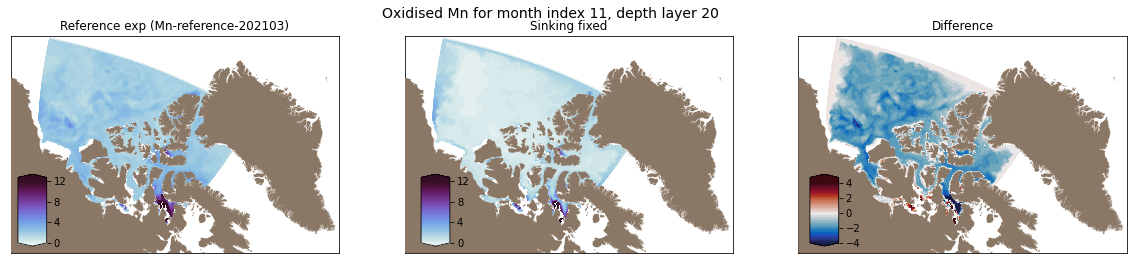

In [103]:
plot_comparison(month=11,layer=20)